In [1]:
import numpy as np
import pandas as pd
from math import exp
from datetime import datetime

In [2]:
# PARAMS A,B,C
def c(k_ds):
    return k_ds

# ALPHA,OMEGA,LAMBDA

def alpha(k_ds):
    return ((a-k_ds)**2 + b**2 + 2*a*b +2*b*k_ds)**0.5

def Omegaminus(k_ds):
    return -a+b+k_ds-alpha(k_ds)
    
def Omegaplus(k_ds):
    return -a+b+k_ds+alpha(k_ds)
    
def lambdaplus(k_ds):
    return -0.5*(a+b+k_ds-alpha(k_ds))

def lambdaminus(k_ds):
    return -0.5*(a+b+k_ds+alpha(k_ds))

# DERIVADES DE ALPHA

def dalphadk_ds(k_ds):
    return (-a + b + k_ds)/alpha(k_ds)

# Derivades de ALPHA^-1

def dalpha_1dk_ds(k_ds):
    return -alpha(k_ds)**(-2)*dalphadk_ds(k_ds)

# Omega derivatives order 1

def dOmegaplusdk_ds(k_ds):
    return 1 + dalphadk_ds(k_ds)

def dOmegaminusdk_ds(k_ds):
    return 1 - dalphadk_ds(k_ds)

# LAMBDA ordre 1

def dlambdaplusdk_ds(k_ds):
    return -0.5*(1 - dalphadk_ds(k_ds))

def dlambdaminusdk_ds(k_ds):
    return -0.5*(1 + dalphadk_ds(k_ds))

# PHI1 

def A(k_ds,t):
    return Omegaminus(k_ds)*exp(lambdaminus(k_ds)*t) - Omegaplus(k_ds)*exp(lambdaplus(k_ds)*t)

def phi1(t,k_ds,R):
    return -R*0.5*(1/alpha(k_ds))*A(k_ds,t)

# A Derivatives order 1

def dAdk_ds(k_ds,t):
    
    expr    = dOmegaminusdk_ds(k_ds)*exp(lambdaminus(k_ds)*t) 
    expr    = expr + Omegaminus(k_ds)*exp(lambdaminus(k_ds)*t)*dlambdaminusdk_ds(k_ds)*t 
    expr    = expr - dOmegaplusdk_ds(k_ds)*exp(lambdaplus(k_ds)*t) 
    expr    = expr - Omegaplus(k_ds)*exp(lambdaplus(k_ds)*t)*dlambdaplusdk_ds(k_ds)*t
    
    return expr

# PHI1 derivatives

def dphi1dk_ds(k_ds,R,t):

    return -R*0.5*(dalpha_1dk_ds(k_ds)*A(k_ds,t) + (1/alpha(k_ds))*dAdk_ds(k_ds,t))

# G

def G(k_ds,t,n, hatphi, R):

    suma = 0

    for i in range(0,n):

        suma += dphi1dk_ds(k_ds = k_ds, R=R,t=t[i])*(phi1(t=t[i],k_ds = k_ds, R=R) - hatphi[i])

    return suma

# DG 

def DG(n,k_ds,R,t,hatphi):
    
    suma = 0
    
    for i in range(0,n):
    
        suma += ddphi1dk_ds(k_ds=k_ds,R=R,t=t[i])*(phi1(t=t[i], k_ds = k_ds, R = R)-hatphi[i]) - dphi1dk_ds(k_ds=k_ds,R=R,t=t[i])**2
    
    return suma



In [3]:
def Least_Squares_Method(k_ds_0, R, n, t, hatphi, tol, f):

    k_ds_1 = k_ds_0
    
    k_ds_0 = -999

    count = 0
    
    new_distancia = abs(k_ds_0 - k_ds_1)

    while new_distancia > tol and count < 100000: 

        k_ds_0  = k_ds_1

        aa      = 0
        bb      = 0
        Sk      = 0

        for i in range(0,n):

            Ji = dphi1dk_ds(k_ds=k_ds_0,R = R, t=t[i])
            Deltaxi = hatphi[i] - phi1(t=t[i],k_ds = k_ds_0, R = R)

            Sk += Deltaxi**2

            aa += Ji*Ji 
            bb += Ji*Deltaxi

        Deltak = bb/aa

        k_ds_1 = k_ds_0 + f*Deltak

        Sk1 = 0

        for i in range(0,n):

            Sk1 += hatphi[i] - phi1(t=t[i],k_ds = k_ds_1, R = R)

        dist = abs((Sk - Sk1)/Sk) 

        count = count + 1
        new_distancia = abs(k_ds_0 - k_ds_1)
        
        if dist < tol:
            print("Break")
            break
        
    print("Steps to converge:")
    print(count)
    
    return k_ds_1


In [4]:
def integration_noise(R, L, k1, k_1, k_ds, mu, sigma, t0, Tmax, dt):
    def F1(x,z,j):
        return (k_1*z - k1*L*x) + sigma*noiseG[j]*sqdt
    
    def F2(x,z,j):
        return k1*L*x - (k_1 + k_ds)*z + sigma*noiseG2[j]*sqdt

    def F(x,z):
        return k_1*z - k1*L*x, k1*L*x - (k_1 + k_ds)*z 
    
    sqdt = dt**0.5
    N = int((Tmax-t0)/dt)

    noiseG = list(np.random.normal(mu, sigma, N))
    noiseG2 =list(np.random.normal(mu, sigma, N))

    x = []
    z = []
    times = []

    # condició inicial

    x.append(R)
    z.append(0)
    times.append(t0)

    true_x = [R]
    true_z = [0]

    for j in range(0,N):
        if False:
            noiseG2[j]=0

        x0 = x[j]
        z0 = z[j]

        x0_true = true_x[j]
        z0_true = true_z[j]
        times.append(t0+(j+1)*dt)

        # real integration

        k1x_true,k1z_true = F(x0_true, z0_true)
        k2x_true,k2z_true = F(x0_true+0.5*dt*k1x_true, z0_true + 0.5*dt*k1z_true)
        k3x_true,k3z_true = F(x0_true+0.5*dt*k2x_true, z0_true + 0.5*dt*k2z_true)
        k4x_true,k4z_true = F(x0_true+dt*k3x_true, z0_true + dt*k3z_true)
        true_x.append(x0_true + (1/6)*dt*(k1x_true + 2*k2x_true + 2*k3x_true + k4x_true))
        true_z.append(z0_true + (1/6)*dt*(k1z_true + 2*k2z_true + 2*k3z_true + k4z_true))

        # noise integration
        k1x = F1(x0,z0,j)
        k1z = F2(x0,z0,j)

        k2x = F1(x0 + 0.5*dt*k1x, z0 + 0.5*dt*k1z, j)
        k2z = F2(x0 + 0.5*dt*k1x, z0 + 0.5*dt*k1z,j)

        k3x = F1(x0 + 0.5*dt*k2x, z0 + 0.5*dt*k2z, j)
        k3z = F2(x0 + 0.5*dt*k2x, z0 + 0.5*dt*k2z,j)

        k4x = F1(x0 + dt*k3x, z0 + dt*k3z, j)
        k4z = F2(x0 + dt*k3x, z0 + dt*k3z,j)
        
        if x0 + (1/6)*dt*(k1x + 2*k2x + 2*k3x + k4x) + sigma*noiseG[j]*sqdt < 0:
            x.append(0)
            
        else:
            
            x.append(x0 + (1/6)*dt*(k1x + 2*k2x + 2*k3x + k4x) + sigma*noiseG[j]*sqdt)

        if z0 + (1/6)*dt*(k1z + 2*k2z + 2*k3z + k4z) + sigma*noiseG2[j]*sqdt < 0:
            
            z.append(0)
            
        else:
            
            z.append(z0 + (1/6)*dt*(k1z + 2*k2z + 2*k3z + k4z) + sigma*noiseG2[j]*sqdt)

    dic_integration = {"z": z, "x":x, "t":times, "x_true": true_x, "z_true": true_z}
    df = pd.DataFrame(dic_integration)

    return df 

In [5]:
def plot_integration_noise(df):
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error

    mean = df["z"].mean()
    print("Mean squared error between the real integration and integration with noise:")
    print(mean_squared_error(df["z"], df["z_true"])/mean)

    plt.figure(figsize=(20,10))

    plt.xlabel("Time(min)")
    plt.ylabel("Concentrations(M)")
    plt.plot(df["t"], df["x"], linestyle = "-." , label = "[R](t)", color = "orange")
    plt.plot(df["t"],df["x_true"], label = "[R](t) with noise.", color = "darkred")
    plt.plot(df["t"],df["z"], linestyle = "-.", label = "[LR](t)", color = "deepskyblue")
    plt.plot(df["t"],df["z_true"], label = "[LR](t) with noise.", color = "darkblue")
    plt.legend()
    plt.show()

    return

In [6]:
def main():
    
    global k_ds, k1, k_1, L, R, sigma,noiseG2, noiseG,dt

    # Change the values of the parameters here
    k_1  = 0.06
    k1   = 4.6*10**5
    k_ds = 0.15
    R    = 10**(-9)
    L    = 310*10**(-9)
    dt   = 0.001
    
    t0   = 0
    Tmax = 20
    mu, sigma = 10**(-9), 4*10**(-6) # mean and standard deviation
    
    df = integration_noise(R = R, L = L, k1 = k1, k_1 = k_1, k_ds = k_ds, mu = mu, sigma = sigma, t0 = t0, Tmax = Tmax, dt=dt)
    
    # To look at the integration
    plot_integration_noise(df)
    
    # To reduce the amount of data
    df["drop_row"] = True
    count = 0

    for index,row in df.iterrows():
        count = count +1 
        if count % 50 == 0:
             df.at[index,"drop_row"] = False
    df = df[df["drop_row"] == False]
    
    hatphi_x = list(df["x"])
    hatphi_z = list(df["z"])
    t = list(df["t"])
    n = len(t)

    global a,b

    a   = k1*L
    b   = k_1

    k_ds_orig   = 0.15
    k_ds_0      = 1

    hatphi      = df["x"]

    now = datetime.now()

    k_ds_1 = Least_Squares_Method(k_ds_0 = k_ds_0, R = R, n = n, t = t, hatphi = hatphi_x, tol = 10e-10, f = 0.01)

    after = datetime.now() - now

    print(f"Seconds to converge:{after.total_seconds()}")
    print(f"Original k_ds:{k_ds_orig}")
    print(f"Optimal k_ds:{k_ds_1}")

Mean squared error between the real integration and integration with noise:
1.9410287487094714e-12


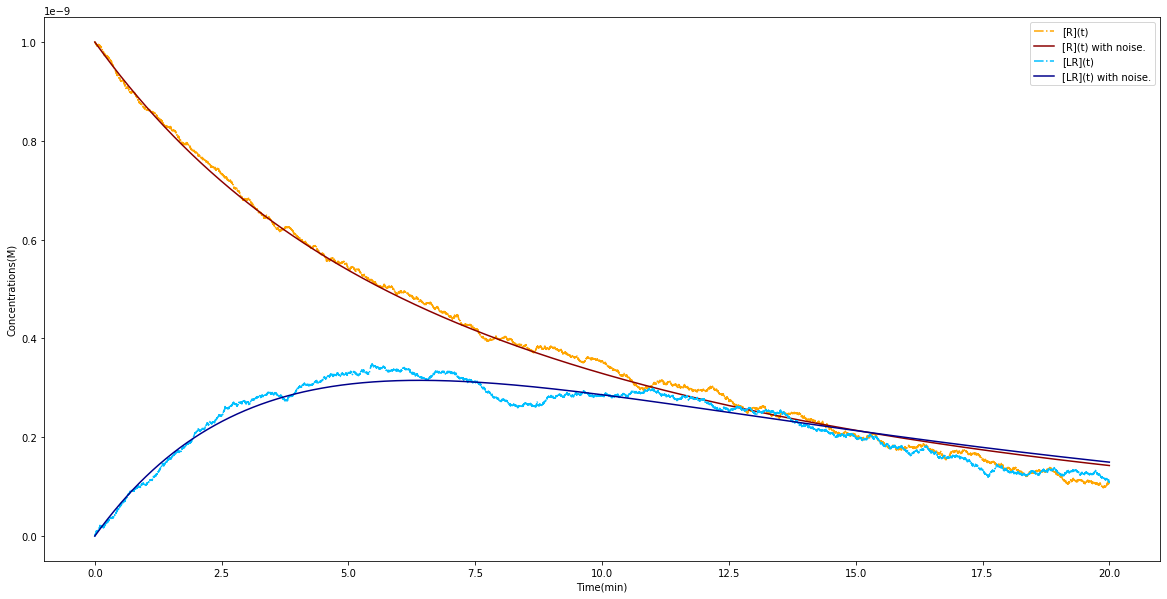

Steps to converge:
1363
Seconds to converge:19.145683
Original k_ds:0.15
Optimal k_ds:0.16867516021354315


In [7]:
main()